In [321]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
import sys
sys.path.append("..")
#import os
from utils.model3 import Net_mask
#from utils.data import Data
#from utils.loss_experiment import Loss
#from scripts.parameters import get_parameters
import torch
#import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [323]:
model = Net_mask()
model.load_state_dict(torch.load(f'../saved_models/model_infinite/2/model_weights.pth'))

<All keys matched successfully>

In [324]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
#tau2 = 1000 # 1/tau2 is the noise added to the diagonal
#tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
#sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
#tensor_mu_m = torch.zeros(n_param)

#tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
#tensor_Sigma_eps = torch.eye(n_param)*sigma2_eps
#tensor_mu_eps = tensor_mu_m 

In [325]:
def loss(tensor_input, tensor_output):
    tensor_Psi = tensor_output
    tensor_Gd = tensor_input[:,:n_param]
    tensor_mask = tensor_input[:,n_param:]
    tensor_GPsi = tensor_Psi*tensor_mask

    # data residual loss
    tensor_squared_error = torch.square(tensor_GPsi - tensor_Gd)
    tensor_squared_error_sum = torch.sum(tensor_squared_error, [0, 1])
    tensor_data_fit_loss = tensor_squared_error_sum
    tensor_data_fit_loss *= 1/0.01

    # data regularization loss
    tensor_PsiQ_m = torch.matmul(tensor_Psi, tensor_Q_m)
    tensor_PsiQ_m = torch.unsqueeze(tensor_PsiQ_m, 1)
    tensor_Psi = torch.unsqueeze(tensor_Psi, 2)
    tensor_PsiQ_mPsi = torch.bmm(tensor_PsiQ_m, tensor_Psi).squeeze(2)
    tensor_data_regularization_loss = torch.sum(tensor_PsiQ_mPsi)

    return tensor_data_fit_loss + tensor_data_regularization_loss

In [326]:
all_test_obses = torch.load(f'../data/test_observations/test_set_full/all_test_obses.pt')
all_test_solutions = torch.load(f'../data/test_observations/test_set_full/all_test_solutions.pt')

In [327]:
n_points = 0
test = all_test_obses[n_points]
analytical_sol = all_test_solutions[n_points]
pred = model(test)
#print(test)
#print(pred)
print(loss(test, pred))
print(loss(test, analytical_sol))
#print(loss)

tensor(76.1834, grad_fn=<AddBackward0>)
tensor(0.0839)


In [328]:
n_points = 2
n_bnn = 100
test_set = all_test_obses[n_points]
bnn_losses = torch.zeros(n_bnn)
for i in range(n_bnn):
    model_bnn = Net_mask()
    model_bnn.load_state_dict(torch.load(f'../saved_models/rml_100/pos/{i}/model_weights.pth'))
    out = model_bnn(test_set)
    bnn_losses[i] = loss(test_set, out)

(array([ 4.,  2.,  4.,  6.,  7.,  7.,  5., 12., 13.,  2.,  4., 10.,  4.,
         3.,  5.,  2.,  5.,  4.,  0.,  1.]),
 array([2850.4678, 2857.4358, 2864.4036, 2871.3716, 2878.3396, 2885.3076,
        2892.2754, 2899.2434, 2906.2114, 2913.1792, 2920.1472, 2927.1152,
        2934.083 , 2941.051 , 2948.019 , 2954.9868, 2961.9548, 2968.9229,
        2975.8909, 2982.8586, 2989.8267], dtype=float32),
 <BarContainer object of 20 artists>)

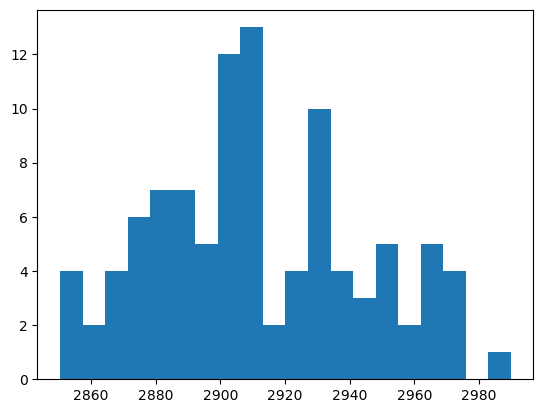

In [329]:
plt.hist(bnn_losses.detach(), bins=20)

In [330]:
max_points = 6
n_points = 4
n_bnn = 100
analytical_losses = torch.zeros(max_points)
map_losses = torch.zeros(max_points)
#bnn_avg_losses = torch.zeros(max_points)
bnn_losses_all_test_obses_e4 = torch.zeros(max_points, n_bnn)
bnn_losses_all_test_obses_e5 = torch.zeros(max_points, n_bnn)
#test_set = all_test_obses[n_points]
for p in range(max_points):
    test_set_points = all_test_obses[p]
    test_set_solution = all_test_solutions[p]

    #bnn_losses_points = torch.zeros(n_bnn)
    for i in range(n_bnn):
        model_bnn_e5 = Net_mask()
        model_bnn_e5.load_state_dict(torch.load(f'../saved_models/rml_100/pos/{i}/model_weights.pth'))
        out_e5 = model_bnn_e5(test_set_points)
        bnn_losses_all_test_obses_e5[p,i] = loss(test_set_points, out)
        model_bnn_e4 = Net_mask()
        model_bnn_e4.load_state_dict(torch.load(f'../saved_models/rml_100_1.0e+04/pos/{i}/model_weights.pth'))
        out_e4 = model_bnn_e4(test_set_points)
        bnn_losses_all_test_obses_e4[p,i] = loss(test_set_points, out)

    analytical_losses[p] = loss(test_set_points, test_set_solution)
    map_losses[p] = loss(test_set_points, model(test_set_points))
    #bnn_avg_losses[p] = torch.mean(bnn_losses_all_test_obses[p,:])

In [331]:
title = f'{"Type":10} | {"Statistic":10} | {"data amount":13} | {1:8} | {2:8} | {3:8} | {4:8} | {5:8} | {6:8} |'
analytical_string = f'{"analytical":10} | {"mean":10} | {"":13} |'
map_string = f'{"MAP":10} | {"mean":10} | {"Infinite":13} |'
avg_bnn_string = f'{"100 BNN":10} | {"mean":10} | {"1e4":13} |'
single_bnn_string = f'{"Single BNN":10} | {"mean":10} | {"1e4":13} |'
for i in range(max_points):
    analytical_string += f' {analytical_losses[i]:8.2f} |' 
    map_string += f' {map_losses[i]:8.2f} |' 
    avg_bnn_string += f' {torch.mean(bnn_losses_all_test_obses[i,:]):8.2f} |' 
    single_bnn_string += f' {bnn_losses_all_test_obses[i,1]:8.2f} |' 
print(title)
print('-'*110)
print(analytical_string)
print(map_string)
print(avg_bnn_string)
print(single_bnn_string)


Type       | Statistic  | data amount   |        1 |        2 |        3 |        4 |        5 |        6 |
--------------------------------------------------------------------------------------------------------------
analytical | mean       |               |     0.08 |  1242.11 |  2523.80 |  4490.51 |  6545.11 |  8909.74 |
MAP        | mean       | Infinite      |    76.18 |  1273.57 |  2590.51 |  4555.13 |  6595.78 |  8945.20 |
100 BNN    | mean       | 1e4           |   607.57 |  1659.76 |  2911.93 |  4848.15 |  6871.39 |  9203.95 |
Single BNN | mean       | 1e4           |   667.47 |  1726.73 |  2974.03 |  4900.02 |  6923.20 |  9240.91 |


(array([ 1.,  1.,  2.,  6.,  3.,  9., 11., 10., 11.,  8.,  8.,  7.,  6.,
         2.,  7.,  2.,  2.,  3.,  0.,  1.]),
 array([9144.894, 9151.351, 9157.809, 9164.266, 9170.724, 9177.181,
        9183.639, 9190.096, 9196.554, 9203.011, 9209.469, 9215.926,
        9222.383, 9228.841, 9235.298, 9241.756, 9248.213, 9254.671,
        9261.128, 9267.586, 9274.043], dtype=float32),
 <BarContainer object of 20 artists>)

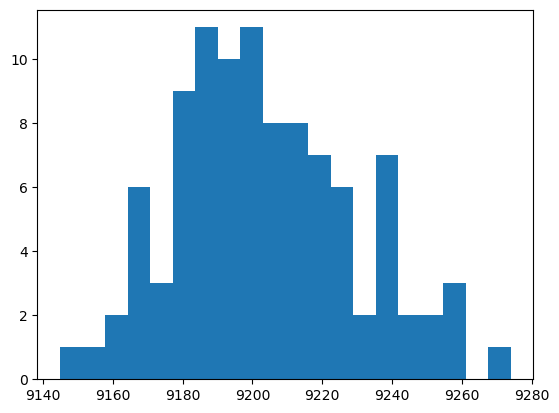

In [332]:
n_points = 5
plt.hist(bnn_losses_all_test_obses[n_points,:].detach(), bins=20)